In [5]:
from data.data_loader import data_preprocess, get_data
from utils.tools import EarlyStopping, save_exp_result, load_exp_result
from utils.tools import plot_metric, plot_loss_variation, plot_metric_variation
from utils.metrics import test_metric
from models.model import LSTM
from core.exp_LSTM import train, validate, test, predict

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pandas_datareader import data as pdr
from dateutil.parser import parse
import yfinance as yf
yf.pdr_override()

import argparse
import openpyxl as opx
import xlrd
import time
import math
import seaborn as sns
import random
from copy import deepcopy
from pytimekr import pytimekr

from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torch

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import font_manager, rc
# matplotlib.rcParams['axes.unicode_minus'] = False
# font_path = "C:/Windows/Fonts/malgun.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)
# %matplotlib inline
# plt.rc("font", family = "Malgun Gothic")


# Data

In [6]:
tesla = pdr.get_data_yahoo('TSLA')

[*********************100%***********************]  1 of 1 completed


In [8]:
# 종가만 활용
df = tesla[['Close']]

In [9]:
capacity = max(df['Close'])

In [10]:
prep = data_preprocess(df, tgt_column='Close', train_ratio=0.7, test_ratio=0.1)

In [11]:
train_data, val_data, test_data = prep.preprocess()

In [12]:
print(train_data.shape, val_data.shape,test_data.shape)

(2207, 6) (632, 6) (315, 6)


In [ ]:
# input_window = 4
# output_window = 2
# train_set = get_data(val_data, input_window, output_window)
# val_set = get_data(val_data, input_window, output_window)
# test_set = get_data(test_data, input_window, output_window)
# partition = {'train':train_set, 'val':val_set, 'test':test_set}

In [ ]:
# train_loader = DataLoader(partition['train'], batch_size=256, shuffle=True, num_workers=0)
# val_loader = DataLoader(partition['val'], batch_size=1, shuffle=False, num_workers=0)

In [ ]:
# for data in val_loader:
#     seq_X,seq_y = data
#     print(seq_X,seq_y)
#     print(seq_X.shape, seq_y.shape)

# Exculsive training

## Hyperparameters

In [15]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
parser = argparse.ArgumentParser()
args = parser.parse_args("")

# ==== Data sequence ==== #
args.input_window = 7
args.output_window = 5

# ===== LSTM model capacity ==== #
args.input_dim = 6
args. hid_dim = 50
args.n_layers =2

# ==== LSTM model regularization ==== #
args.dropout = 0.05
args.l2 = 0
args.use_bn = True

# ==== Optimizer & Training ====#
args.use_amp = True
args.optim = 'Adam'
args.gamma = 0.95
args.lr = 0.0005
args.epoch = 500
args.batch_size = 32
args.early_stopping_patience = 50

train_set = get_data(train_data, args.input_window, args.output_window)
val_set = get_data(val_data, args.input_window, args.output_window)
test_set = get_data(test_data, args.input_window, args.output_window)
partition = {'train':train_set, 'val':val_set, 'test':test_set}

print(args)
test_model = LSTM(args.input_dim, args.hid_dim, args.output_window, args.n_layers, args.batch_size, args.dropout, args.use_bn)
test_model.cuda()

criterion = nn.MSELoss() # Loss function
criterion.cuda()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

if args.optim == 'RMSprop':
    optimizer = optim.RMSprop(test_model.parameters(), lr=args.lr, weight_decay=args.l2)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=args.gamma)
elif args.optim == 'Adam':
    optimizer = optim.Adam(test_model.parameters(), lr=args.lr, weight_decay=args.l2)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=args.gamma)
elif args.optim == 'AdamW':
    optimizer = optim.AdamW(test_model.parameters(), lr=args.lr, weight_decay=args.l2)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=args.gamma)
else:
    raise ValueError('In-valid optimizer choice')

Namespace(batch_size=32, dropout=0.05, early_stopping_patience=50, epoch=500, gamma=0.95, hid_dim=50, input_dim=6, input_window=7, l2=0, lr=0.0005, n_layers=2, optim='Adam', output_window=5, use_amp=True, use_bn=True)


In [16]:
# ===== List for epoch-wise data ====== #
train_losses = [] # s 붙은건 list 나타내기 위함 
val_losses = []
train_metrics = []
val_metrics = []
# ===================================== #

# ==== Early stopping object 초기화 ====#
early_stopping = EarlyStopping(patience = args.early_stopping_patience, verbose = True)

for epoch in range(args.epoch):  # loop over the dataset multiple times
    ts = time.time()
    test_model, train_loss, train_metric = train(test_model, partition, optimizer, criterion, args)
    val_loss, val_metric = validate(test_model, partition, criterion, args)
    te = time.time()

    # ====== Add Epoch Data ====== #
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_metrics.append(train_metric)
    val_metrics.append(val_metric)
    # ============================ #
    print('Epoch {}, Metric(train/val): {:2.4f}/{:2.4f}, Loss(train/val) {:2.6f}/{:2.6f}. Took {:2.2f} sec'.format(epoch, train_metric, val_metric, train_loss, val_loss, te-ts))
    
    # ==== Early_stopping은 validation metric이 감소하였는지 체크, 만약 감소하였을 경우 현재 모델을 checkpoint로 생성 == #
    
    early_stopping(val_metric, test_model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break

# ==== Best case가 저장되어 있는 last checkpoint 로드 (callback)
test_model.load_state_dict(torch.load('checkpoint.pt'))


Epoch 0, Metric(train/val): 33.7914/100.5390, Loss(train/val) 0.323899/0.000000. Took 0.42 sec
Validation metric decreased (inf --> 100.538987).  Saving model ...
Epoch 1, Metric(train/val): 14.3872/96.7208, Loss(train/val) 0.052732/0.000000. Took 0.35 sec
Validation metric decreased (100.538987 --> 96.720763).  Saving model ...
Epoch 2, Metric(train/val): 12.4994/95.3985, Loss(train/val) 0.038729/0.000000. Took 0.35 sec
Validation metric decreased (96.720763 --> 95.398475).  Saving model ...
Epoch 3, Metric(train/val): 14.7696/91.7503, Loss(train/val) 0.055004/0.000000. Took 0.34 sec
Validation metric decreased (95.398475 --> 91.750260).  Saving model ...
Epoch 4, Metric(train/val): 14.7235/89.1428, Loss(train/val) 0.055669/0.000000. Took 0.34 sec
Validation metric decreased (91.750260 --> 89.142844).  Saving model ...
Epoch 5, Metric(train/val): 12.9639/87.6962, Loss(train/val) 0.044077/0.000000. Took 0.34 sec
Validation metric decreased (89.142844 --> 87.696218).  Saving model ...
E

Epoch 60, Metric(train/val): 10.5661/102.1572, Loss(train/val) 0.026415/0.000000. Took 0.35 sec
EarlyStopping counter: 47 out of 50
Epoch 61, Metric(train/val): 9.6711/104.0651, Loss(train/val) 0.022403/0.000000. Took 0.36 sec
EarlyStopping counter: 48 out of 50
Epoch 62, Metric(train/val): 9.5297/107.3048, Loss(train/val) 0.022217/0.000000. Took 0.34 sec
EarlyStopping counter: 49 out of 50
Epoch 63, Metric(train/val): 9.7761/104.3763, Loss(train/val) 0.022847/0.000000. Took 0.35 sec
EarlyStopping counter: 50 out of 50
Early stopping


<All keys matched successfully>

# Test

In [17]:
test(test_model, partition, args, capacity=capacity)

test shape: (9, 32, 5) (9, 32, 5)
test shape: (288, 5, 1) (288, 5, 1)
mse:48391.0145, mae:211.6542, Cv_rmse:77.2072, kr_error:51.6268, mape:0.7297, mspe:0.5385


77.2071911323502

# Save the model

In [ ]:
torch.save(test_model.state_dict(), "./weights/test.pth")

# Pred

In [ ]:
test_model.load_state_dict(torch.load("./weights/test.pth"))

In [18]:
y_pred, y_true = predict(test_model, partition, args)

(9, 32, 5) (9, 32, 5)
(288, 5, 1) (288, 5, 1)


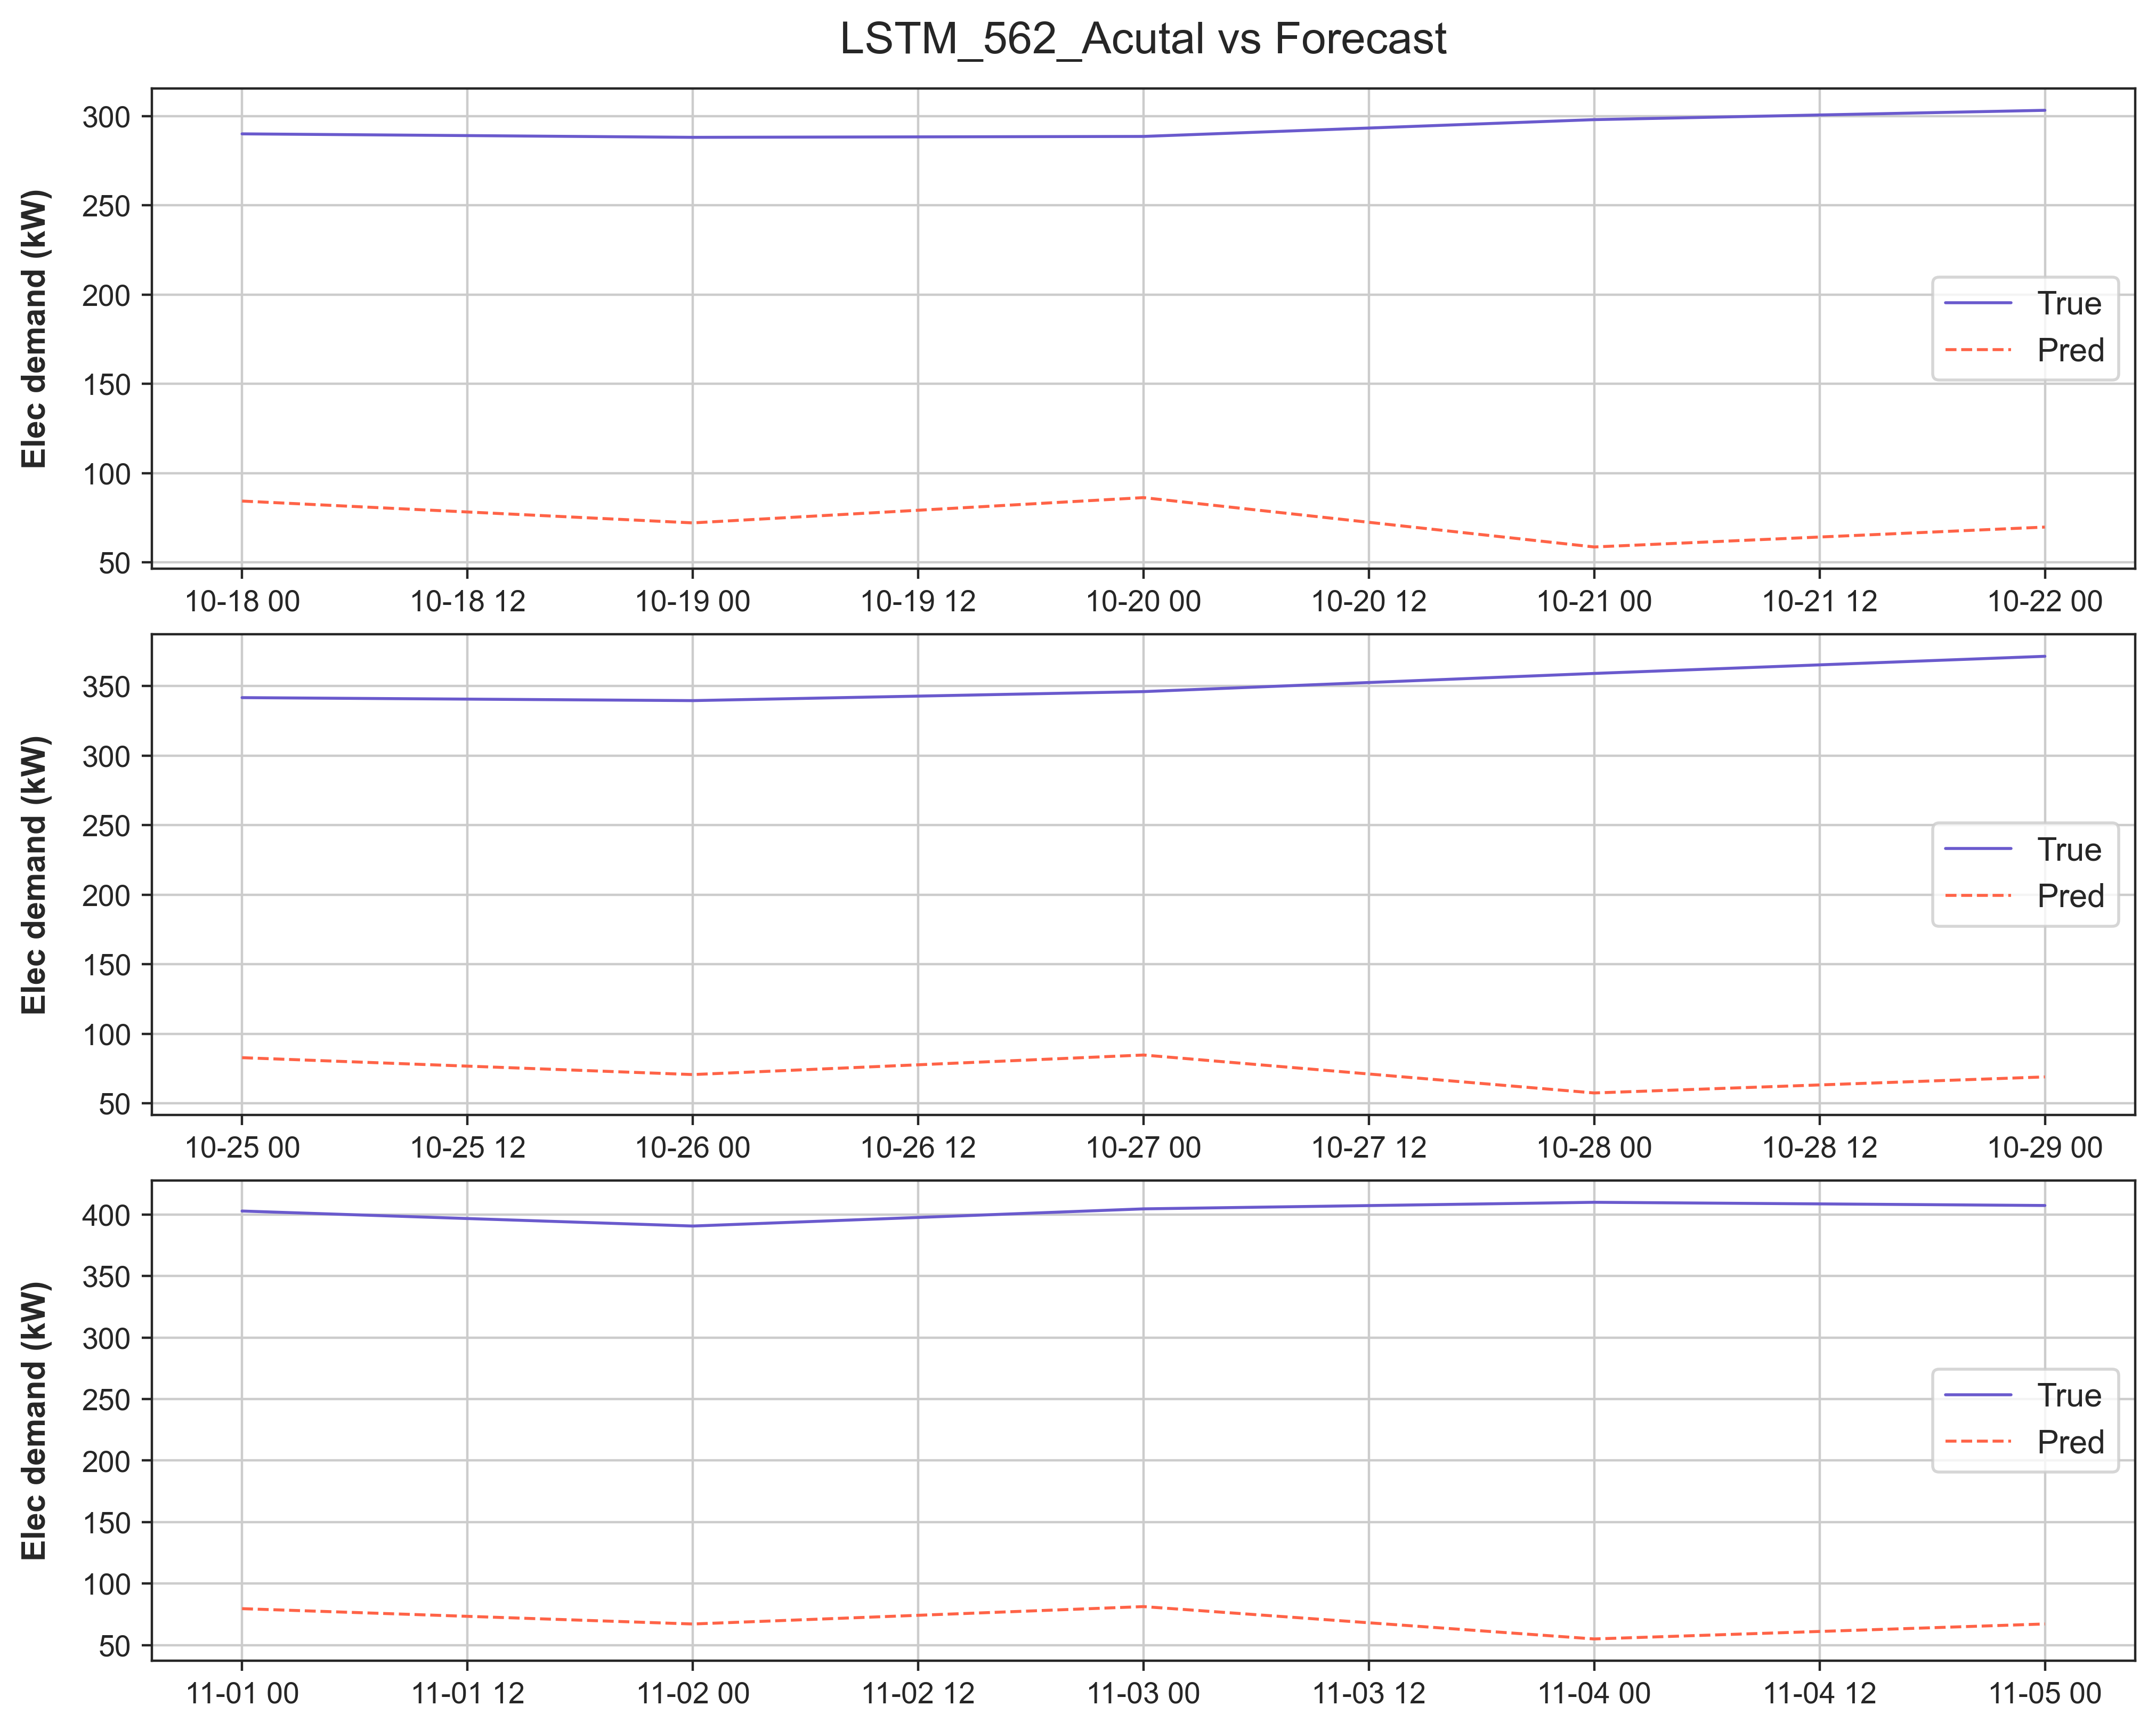

In [20]:
sns.set_style('ticks')
tick_labelsize=10
legend_fontsize=11
label_fontsize=11
fig_hor = 10
fig_time_step = 0
x_index1=df.iloc[len(df)-len(test_data)+args.input_window:].index[fig_time_step + args.output_window*0 : args.output_window*1+fig_time_step]
x_index2=df.iloc[len(df)-len(test_data)+args.input_window:].index[fig_time_step + args.output_window*1 : args.output_window*2+fig_time_step]
x_index3=df.iloc[len(df)-len(test_data)+args.input_window:].index[fig_time_step + args.output_window*2 : args.output_window*3+fig_time_step]


fig = plt.figure(figsize=(fig_hor,8), constrained_layout=True, dpi=400) # 가로 x 세로

ax1 = fig.add_subplot(3,1,1)
ax1.plot(x_index1, y_true[fig_time_step+args.output_window*0], color = 'slateblue', label='True', lw = 1.0, alpha=1.0)
ax1.plot(x_index1, y_pred[fig_time_step+args.output_window*0], color = 'tomato', label='Pred', lw = 1.0, alpha=1.0, linestyle='--')
ax1.set_ylabel('Elec demand (kW)', fontweight='bold', fontsize=label_fontsize, labelpad=10)
ax1.set_title('LSTM_562_Acutal vs Forecast', fontsize=15, pad=12)
ax1.tick_params(axis='x', labelsize=tick_labelsize)
ax1.tick_params(axis='y', labelsize=tick_labelsize)
ax1.legend(loc='best', fontsize=legend_fontsize)
# ax1.set_ylim(25, 105)
ax1.grid()

ax2 = fig.add_subplot(3,1,2)
ax2.plot(x_index2, y_true[fig_time_step+args.output_window*1], color = 'slateblue', label='True', lw = 1.0, alpha=1.0)
ax2.plot(x_index2, y_pred[fig_time_step+args.output_window*1], color = 'tomato', label='Pred', lw = 1.0, alpha=1.0, linestyle='--')
ax2.set_ylabel('Elec demand (kW)', fontweight='bold', fontsize=label_fontsize, labelpad=10)
ax2.tick_params(axis='x', labelsize=tick_labelsize)
ax2.tick_params(axis='y', labelsize=tick_labelsize)
ax2.legend(loc='best', fontsize=legend_fontsize)
# ax2.set_ylim(25, 105)
ax2.grid()

ax3 = fig.add_subplot(3,1,3)
ax3.plot(x_index3, y_true[fig_time_step+args.output_window*2], color = 'slateblue', label='True', lw = 1.0, alpha=1.0)
ax3.plot(x_index3, y_pred[fig_time_step+args.output_window*2], color = 'tomato', label='Pred', lw = 1.0, alpha=1.0, linestyle='--')
ax3.set_ylabel('Elec demand (kW)', fontweight='bold', fontsize=label_fontsize, labelpad=10)
ax3.tick_params(axis='x', labelsize=tick_labelsize)
ax3.tick_params(axis='y', labelsize=tick_labelsize)
ax3.legend(loc='best', fontsize=legend_fontsize)
# ax3.set_ylim(25, 105)
ax3.grid()


plt.show()

# Experiment

## Experimental block

In [ ]:
def experiment(partition, args):
  
    model = LSTM(args.input_dim, args.hid_dim, args.output_window, args.n_layers, args.batch_size, args.dropout, args.use_bn)
    model.cuda()

    criterion = nn.MSELoss()
    criterion.cuda()    
    
    if args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=args.gamma)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=args.gamma)
    elif args.optim == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.l2)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=args.gamma)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = [] # s 붙은건 list 나타내기 위함 
    val_losses = []
    train_metrics = []
    val_metrics = []
    # ===================================== #
    
    early_stopping = EarlyStopping(patience = args.early_stopping_patience, verbose = True)
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        model, train_loss, train_metric = train(model, partition, optimizer, criterion, args)
        val_loss, val_metric = validate(model, partition, criterion, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_metrics.append(train_metric)
        val_metrics.append(val_metric)
        # ============================ #
        
        print('Epoch {}, Metric(train/val): {:2.4f}/{:2.4f}, Loss(train/val) {:2.4f}/{:2.4f}. Took {:2.2f} sec'.format(epoch, train_metric, val_metric, train_loss, val_loss, te-ts))
        scheduler.step()    
        
        # ==== Early_stopping은 validation metric이 감소하였는지 체크, 만약 감소하였을 경우 현재 모델을 checkpoint로 생성 == #    
        early_stopping(val_metric, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    test_metric = test(model, partition, args, capacity)
    
    # ==== Best case가 저장되어 있는 last checkpoint 로드 (callback)
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_metrics'] = train_metrics
    result['val_metrics'] = val_metrics
    result['train_metric'] = train_metric
    result['val_metric'] = val_metric
    result['test_metric'] = test_metric
    return vars(args), result #args를 vars로 감싸면 dictionary가 됨 
    # ===================================== #

## Testing the hyperparameters

In [ ]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
parser = argparse.ArgumentParser()
args = parser.parse_args("")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
args.exp_name = 'exp1_input_window_output_window'

# ==== Data sequence ==== #
args.input_window = 48
args.output_window = 24

# ===== LSTM model capacity ==== #
args.input_dim = 6
args. hid_dim = 50
args.n_layers =2

# ==== LSTM model regularization ==== #
args.dropout = 0.05
args.l2 = 0
args.use_bn = True

# ==== Optimizer & Training ====#
args.use_amp = True
args.optim = 'Adam'
args.gamma = 0.95
args.lr = 0.0005
args.epoch = 1
args.batch_size = 32
args.early_stopping_patience = 50

# ====== Experiment Variable ====== #
name_var1 = 'input_window'
name_var2 = 'output_window'
list_var1 = [24*6*1, 24*6*2]
list_var2 = [24*6*1, 24*6*2]

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1) # 실험변수명 자동화 처리 되도록 하는 구문, string attribute 값 지정되면 그 항목값으로 지정 
        setattr(args, name_var2, var2)
        print(args)        
        
        # ====== Data ======== #        
        train_set = get_data(train_data, args.input_window, args.output_window)
        val_set = get_data(val_data, args.input_window, args.output_window)
        test_set = get_data(test_data, args.input_window, args.output_window)
        partition = {'train':train_set, 'val':val_set, 'test':test_set}
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

## Result posting

In [ ]:
var1 = 'input_window'
var2 = 'output_window'
df = load_exp_result('exp1')

plot_metric(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=True) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_metric_variation(var1, var2, df, margin_titles=True, sharey=True)